In [1]:
%matplotlib inline
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import scipy.stats as sps

In [2]:
def simulation_X(K, theta, n):
    simul_Z = npr.choice(range(1, K+1), p=theta[0], size=n)
    return [sps.multivariate_normal(theta[1][z-1], theta[2][z-1]).rvs() for z in simul_Z], simul_Z


In [3]:
# def pdf_X_1D(x, theta):
#     # print("*", 1 / (np.sqrt(2 * np.pi * theta[2])))
#     return np.sum(theta[0] * 1 / (np.sqrt(2 * np.pi * theta[2])) * np.exp(-1/2 * (x - theta[1]) ** 2 / theta[2]))

def pdf_X(x, theta:tuple[np.ndarray]):
    return theta[0].dot(np.array([sps.multivariate_normal(theta[1][k], theta[2][k]).pdf(x) for k in range(len(theta[0]))]))

# def pdf_X2(x, theta):
#     d = x.shape[0]
#     diff = x - theta[1]
#     exp_fact = np.exp(-0.5 * np.array([d.T @ sigma @ d for d, sigma in zip(diff, np.linalg.inv(theta[2]))]))_çik;
#     # print("**", x, "*", theta[1], "\n***", diff)
#     # print("*", diff.T.shape)
#     # print("*", np.linalg.inv(theta[2]).shape)
#     # print("*", diff.shape)
#     return np.sum(theta[0] * 1 / ((2 * np.pi) ** (d/2) * np.sqrt(np.linalg.det(theta[2]))) * exp_fact)

Pi: [0.18451732 0.29117779 0.21404211 0.18250647 0.12775631]
Mu: [[-0.84272405]
 [ 1.96992445]
 [ 1.26611853]
 [-0.50587654]
 [ 2.54520078]]
Sigma: [[[6.57343766e-01]]

 [[2.75662693e-01]]

 [[1.39673158e-01]]

 [[5.17411179e-03]]

 [[5.39375049e+00]]]


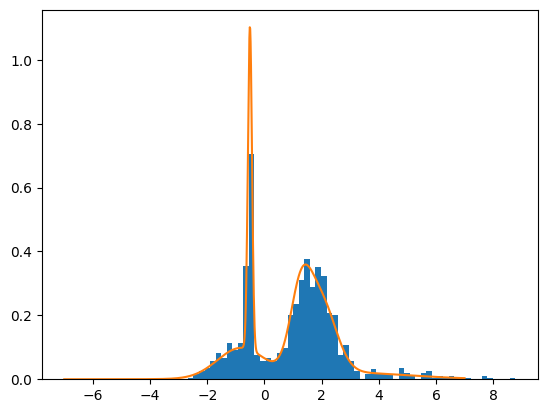

In [4]:
d = 1
K = 5
np.random.seed(0)
Pi = np.random.dirichlet(np.ones(K))
print("Pi:", Pi)
Mu = np.random.randn(K, 1)
print("Mu:", Mu)
Sigma = np.array([np.random.uniform(0, abs(mu)**2, size=(1,1)) for mu in Mu])
print("Sigma:", Sigma)
theta = (Pi, Mu, Sigma)

N = 1000
b = int(N ** (1./3.)) * 7
X_samples, Z_samples = simulation_X(K, theta, N)
# print("X samples: ", X_samples)
# print("Z samples: ", Z_samples)

plt.hist(X_samples, density=True, label=f"Echantillon de X de taille {N}", bins=b)

X = np.linspace(-7, 7, 1000).reshape(1000, 1)
plt.plot(X, np.array([pdf_X(x, theta) for x in X]), label="Densité de probabilité de X")

## 2 Algorithme d’estimation de paramètres de mélange gaussien

In [16]:
def likelihood(K, theta, X):
    f_theta = np.array([pdf_X(x, theta) for x in X])
    min_val = 1e-300

    return np.log([np.where(f_theta > min_val, f_theta, min_val)]).sum() 

In [6]:
def pdf_Z_X(x, theta):
    # print("theta: ", theta)
    return theta[0] * np.array([sps.multivariate_normal(theta[1][k], theta[2][k]).pdf(x) for k in range(len(theta[0]))]) / pdf_X(x, theta)


def theta_estim(X, K, n_iter = 100):
    n, d = X.shape

    Mu = X[npr.choice(n, K, replace=False)] # We must have n >= K
    Sigma = np.array([np.cov(X.T) + 1e-6 * np.eye(d) for _ in range(K)]) # To have a non null determinant and to follow datas
    Pi = np.ones(K) / K

    Mu_hist = []
    
    while (n_iter > 0):
        # E-step

        theta = (Pi, Mu, Sigma)
        Z = np.array([np.argmax(pdf_Z_X(x, theta)) + 1 for x in X])
        # print("Z:", Z)

        # M-step

        # To optimise
        filter = np.array([Z == k for k in range(1, K+1)])
        # print("filter: ", filter.shape)
        N = np.sum(filter, axis=1)
        print("N:", N)
        X_filtered = np.array([X * filter[k].reshape(n, 1) for k in range (K)])
        # print("X_filtered: ", X_filtered.shape)
        
        _Mu = np.sum(X_filtered, axis=1)
        Mu = np.array([_Mu[k] / N[k] if N[k] != 0 else X[npr.randint(0, n)] for k in range(K)]) # Case where n_k = 0, we consider a random point in X
        # print("Mu: ", Mu)
        Mu_hist.append(Mu)
        
        # We have to transpose first to have d * d at the end
        diff_T = np.array([(X_filtered[k] - Mu[k]) for k in range(K)])
        # print("diff: ", diff_T.shape)
        _Sigma = np.array([d.T.dot(d) for d in diff_T])
        Sigma = np.array([_Sigma[k] / N[k] if N[k] != 0 else np.cov(X.T) + 1e-6 * np.eye(d) for k in range(K)])  # Case where n_k = 0, we consider the init covariance which follows the x_i and has a non nul determinant
        # print("Sigma: ", Sigma)
        
        Pi = N / n
        # print("Pi:", Pi)
        
        n_iter -= 1

    return theta, np.array(Mu_hist)





N: [124  77  99]
N: [105  83 112]
N: [100  90 110]
N: [100  98 102]
N: [100 104  96]
N: [100 106  94]
N: [100 106  94]
N: [100 106  94]
N: [100 106  94]
N: [100 106  94]
N: [100 106  94]
N: [100 106  94]
N: [100 106  94]
N: [100 106  94]
N: [100 106  94]


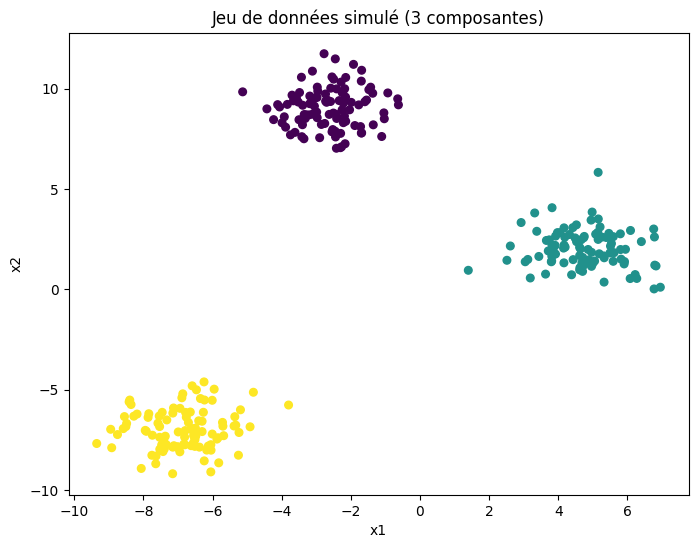

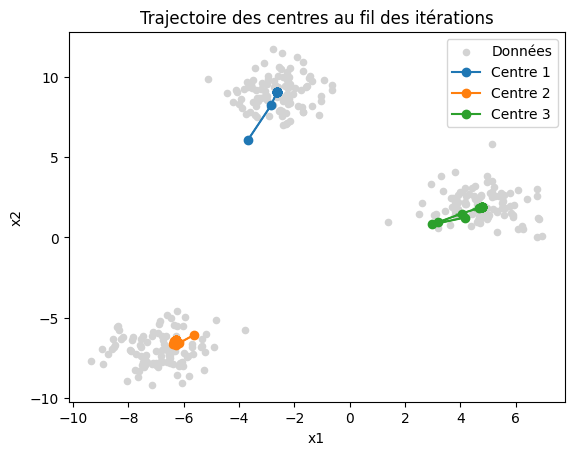

In [7]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# Génération des données
n = 300
K = 3
X, y = make_blobs(n_samples=n, centers=K, n_features=2, cluster_std=1.0, random_state=42)

theta, Mu_hist = theta_estim(X, K, n_iter=15)

# Affichage des points
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, s=30)
plt.title('Jeu de données simulé (3 composantes)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

# Affichage de la trajectoire de chaque centre
m = Mu_hist.shape[1]
plt.scatter(X[:, 0], X[:, 1], c='lightgray', s=20, label='Données')
for k in range(m):
    traj = Mu_hist[:, k, :]
    plt.plot(traj[:, 0], traj[:, 1], marker='o', label=f'Centre {k+1}')
    # Flèches entre les positions successives
    for t in range(len(traj)-1):
        plt.arrow(traj[t, 0], traj[t, 1],
                  traj[t+1, 0] - traj[t, 0], traj[t+1, 1] - traj[t, 1],
                  head_width=0.15, head_length=0.2, fc=f'C{k}', ec=f'C{k}', alpha=0.7, length_includes_head=True)

plt.title("Trajectoire des centres au fil des itérations")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()

### Constat

- Les trajectoires des centres convergent
- Et la convergence est très rapide 
- Oui après quelques itérations, les centres evoluent très peu

## S4/

- La base de dpnnées à 1797 images

-  plot_digits(data) représente graphiquement les 100 échantillons d'images de chiffre (représentées sous forme de matrice de taille 8*8) dans la base de données

## Modèle de mélanges gaussiens pour la génération de données

In [8]:
# import seaborn as sns; sns.set()
from sklearn.mixture import GaussianMixture as GMM
from sklearn.datasets import load_digits

digits = load_digits()
digits.data.shape

(1797, 64)

(1797, 64)

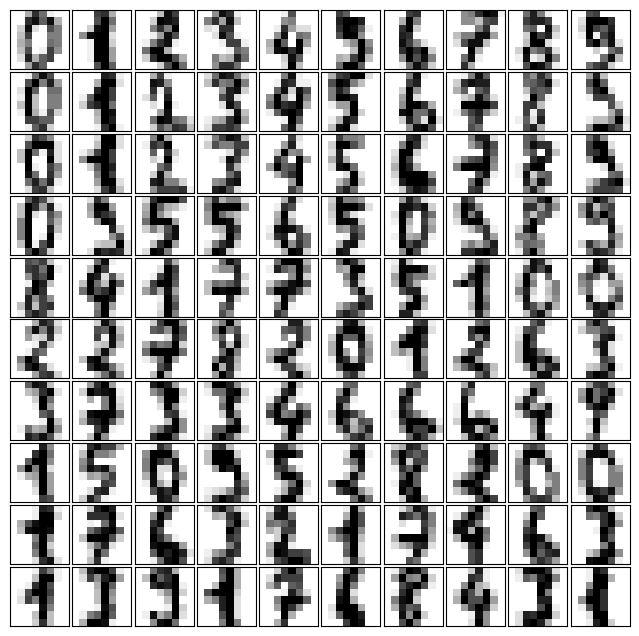

In [9]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

data = digits.data
data.shape

c:\Users\kapoi\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:131: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\kapoi\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\kapoi\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 299, in _count_physical_cores_win32
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\kapoi\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\k

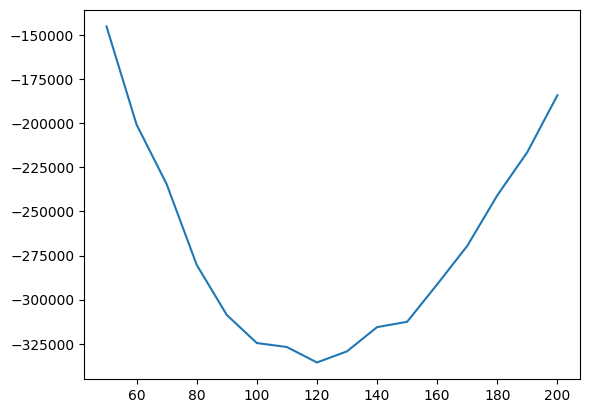

In [10]:
K_components = np.arange(50, 210, 10)
models = [GMM(K, covariance_type='full', random_state=0)
          for K in K_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(K_components, aics)

### S7

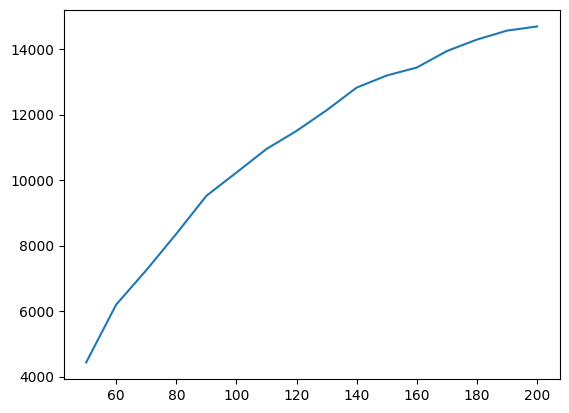

In [21]:
plt.plot(K_components, np.array([likelihood(K, (model.weights_, model.means_, model.covariances_), digits.data[:50]) for K, model in zip(K_components, models)]))


(1797, 64)
-44209.63378548568


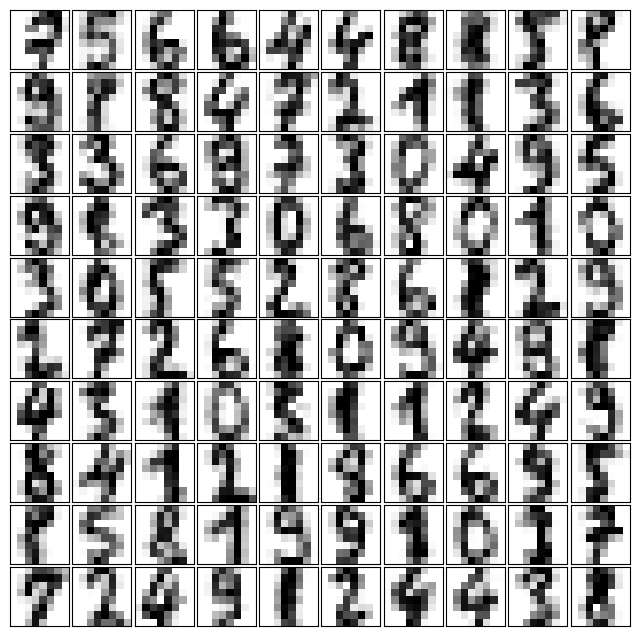

In [20]:
_K = 110
_n = 100
model_K = models[_K // 10 - 5]

print(digits.data.shape)
print(likelihood(K, (model_K.weights_, model_K.means_, model_K.covariances_), digits.data[56]))

theta = (model_K.weights_, model_K.means_, model_K.covariances_)

X_samples, Z_samples = simulation_X(_K, theta, _n)

plot_digits(X_samples)